# COMP 551 — Assignment 2

Authors:
 - Bernier, Audréanne
 - Coull-Neveu, Ben
 - Trachsel-Bourbeau, Anjara

Imports

In [169]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [141]:
# define plotting parameters
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['legend.fancybox'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['figure.autolayout'] = True
plt.rcParams['axes.autolimit_mode'] = 'data'  # default, ensures autoscale uses data
plt.rcParams["font.family"] = "serif"


# set default save directory and parameters
SAVEDIR = './figures/'
os.makedirs(SAVEDIR, exist_ok=True)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

## Functions & Models

### Model Implementations

In [143]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []
            
    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad = gradient_fn(x, y, w)
            w = w - self.learning_rate * grad
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w

In [144]:
class LinearRegression:
    def __init__(self, add_bias=True, l2_reg=0.0, l1_reg=0.0):
        self.add_bias = add_bias
        self.l2_reg = l2_reg
        self.l1_reg = l1_reg
        self.N= None # init N
        self.w = None # init w
        self.num_batches = None # batches for gradient descent
        self.loss = None
        self.loss_history = []
        self.w_history = []
        self.grad_history = []
        self.total_epochs = None

    @staticmethod
    def l2_loss(x, y, w):
      return np.mean((y - (x @ w))**2)

    def fit_analytical(self, x, y):
        """
        Fit the model using the analytical solution.
        """
        # Check shape of x
        if x.ndim == 1:
            x = x[:, None]  # add a dimension for the features
        N = x.shape[0]

        # Add bias term if needed
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])

        # Analytical weight solution using least squares
        self.w = np.linalg.lstsq(x, y, rcond=None)[0]

        # calculate loss for comparisons
        self.loss = LinearRegression.l2_loss(x, y, self.w)
        return self


    def fit_gd_regularized(self, x, y, optimizer, reg_type=None):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        def gradient(x, y, w):
            yh =  x @ w 
            N, D = x.shape
            grad = .5*np.dot(yh - y, x)/N
            # add regularization term (excluding bias term)
            if reg_type=='l1':
                grad[1:] += self.l1_reg * np.sign(w[1:])
            elif reg_type=='l2':
                grad[1:] += self.l2_reg * w[1:]
            else: 
                raise ValueError("reg_type must be 'l1' or 'l2'")
            return grad
        w0 = np.zeros(D)
        self.w = optimizer.run(gradient, x, y, w0)
        return self
    

    def predict(self, x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w  # predict the y values
        return yh


    def __str__(self):
        return f'weights: {self.w}'

### Useful Functions

In [164]:
# sum of squared errors (SSE)
def SSE(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

# Defining y(x)
y = lambda x, err=0: np.log(x+1) * np.cos(x) + np.sin(2*x) + err  # tasks 1-3
y_task4 = lambda x, err=0: -3*x + 8 + 2*err  # task 4

# Gaussian basis function
gaussian = lambda x, mu, sigma=1: np.exp(-((x-mu)/sigma)**2)

In [ ]:
# -- Cross-Validation Functions --

def sample_dataset(N, noise_variance=1):
    # Sample N points uniformly in [0,1] and add Gaussian noise
    x = np.random.uniform(0, 1, N)
    noise = np.sqrt(noise_variance) * np.random.randn(N)
    return x, y(x, noise), noise

def get_gaussian_basis(x, D, sigma=1):
    bases = np.arange(0, D)
    mu = np.min(x) + (np.max(x) - np.min(x))/(D-1) * bases
    phi = gaussian(x[:,None], mu[None,:], sigma=sigma)
    return phi


def compute_bias_variance(y_predictions, y_true):
    """
    y_predict_all has shape (Ndatasets, Nlambda, xshape, 2) 
    """
    # Mean prediction over datasets for l1 and l2; shape (Nlambda, xshape)
    y_mean_pred = np.mean(y_predictions, axis=0)

    # Compute variance for each lambda 
    # mean((prediction - mean prediction)^2) over datasets
    variance = np.mean((y_predictions - y_mean_pred[None,:,:,:])**2, axis=0)
    variance_mean = np.mean(variance, axis=1)  # avg over x values, shape (N_lambda, 2)

    # Compute bias^2 for each lambda
    # bias^2 = (mean prediction - true function)^2
    bias_squared = (y_mean_pred - y_true[None,:,None])**2
    bias_mean = np.mean(bias_squared, axis=1)  # average over x values, shape (N_lambda, 2)

    return bias_mean, variance_mean


def do_l1_reg(x_train, y_train, x_valid, y_valid, reg_coef, learning_rate, max_iters, x_prime=None):
    """Perform L1-regularized linear regression for a single fold.
    """
    # Initialize optimizer and model
    optimizer_l1 = GradientDescent(learning_rate=learning_rate, max_iters=max_iters, record_history=False)
    model_l1 = LinearRegression(l1_reg=reg_coef)

    # Train and predict
    yh_train = model_l1.fit_gd_regularized(x_train, y_train, optimizer_l1, reg_type='l1').predict(x_train)
    yh_val = model_l1.predict(x_valid)
    if x_prime is not None:
        yh_prime = model_l1.predict(x_prime)

    # Compute MSEs
    train_MSE = np.mean((y_train - yh_train) ** 2)
    val_MSE = np.mean((y_valid - yh_val) ** 2)

    return train_MSE, val_MSE, yh_prime


def do_l2_reg(x_train, y_train, x_valid, y_valid, reg_coef, learning_rate, max_iters, x_prime=None):
    """Perform L2-regularized linear regression for a single fold.
    """
    # Initialize optimizer and model
    optimizer_l2 = GradientDescent(learning_rate=learning_rate, max_iters=max_iters, record_history=False)
    model_l2 = LinearRegression(l2_reg=reg_coef)

    # Train and predict
    yh_train = model_l2.fit_gd_regularized(x_train, y_train, optimizer_l2, reg_type='l2').predict(x_train)
    yh_val = model_l2.predict(x_valid)
    if x_prime is not None:
        yh_prime = model_l2.predict(x_prime)

    # Compute MSEs
    train_MSE = np.mean((y_train - yh_train) ** 2)
    val_MSE = np.mean((y_valid - yh_val) ** 2)

    return train_MSE, val_MSE, yh_prime


def k_fold_cv(x_data, y_data, err, num_folds, reg_coef, learning_rate, max_iters, x_prime):
    """
    Perform k-fold cross-validation for a single regularization coefficient.
    Returns averaged train/validation MSEs and their std for L1 and L2.
    """
    # Split data into k folds
    x_splits = np.array_split(x_data, num_folds, axis=0)
    y_splits = np.array_split(y_data, num_folds, axis=0)

    # Initialize storage for fold MSE results (shape (num_folds,))
    l1_train_MSE, l1_val_MSE = [], []
    l2_train_MSE, l2_val_MSE = [], []
    # Store y predictions for each fold; shape (Nfolds, Ndata)
    y_pred_fold_l1 = []
    y_pred_fold_l2 = []

    for val_fold in range(num_folds):
        # define training (9 folds) and validation (1 fold) sets
        x_valid, y_valid = x_splits[val_fold], y_splits[val_fold]
        x_train = np.concatenate([s for j, s in enumerate(x_splits) if j != val_fold])
        y_train = np.concatenate([s for j, s in enumerate(y_splits) if j != val_fold])

        # L1 regularization
        train_mse, val_mse, yh_pred_l1 = do_l1_reg(x_train, y_train, x_valid, y_valid, 
                                                  reg_coef, learning_rate, max_iters,
                                                  x_prime)
        y_pred_fold_l1.append(yh_pred_l1)
        l1_train_MSE.append(train_mse)
        l1_val_MSE.append(val_mse)

        # L2
        train_mse, val_mse, yh_pred_l2 = do_l2_reg(x_train, y_train, x_valid, y_valid, 
                                                  reg_coef, learning_rate, max_iters,
                                                  x_prime)
        y_pred_fold_l2.append(yh_pred_l2)
        l2_train_MSE.append(train_mse)
        l2_val_MSE.append(val_mse)
    
    # Average predictions over folds; shape (len(x),)
    y_pred_fold_l1 = np.mean(np.array(y_pred_fold_l1), axis=0)
    y_pred_fold_l2 = np.mean(np.array(y_pred_fold_l2), axis=0)

    # Return averages and stds for this lambda
    return {
        'l1_MSE': {
            'avg_train_MSE': np.mean(l1_train_MSE),
            'train_MSE_err': np.std(l1_train_MSE),
            'avg_val_MSE': np.mean(l1_val_MSE),
            'val_MSE_err': np.std(l1_val_MSE),
        },
        'l2_MSE': {
            'avg_train_MSE': np.mean(l2_train_MSE),
            'train_MSE_err': np.std(l2_train_MSE),
            'avg_val_MSE': np.mean(l2_val_MSE),
            'val_MSE_err': np.std(l2_val_MSE),
        },
        'l1_y_pred': y_pred_fold_l1,
        'l2_y_pred': y_pred_fold_l2
    }

In [173]:
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

## Task 1: Linear Regression with Non-Linear Basis Functions

#### Data Generation & Non-Linear Basis Functions

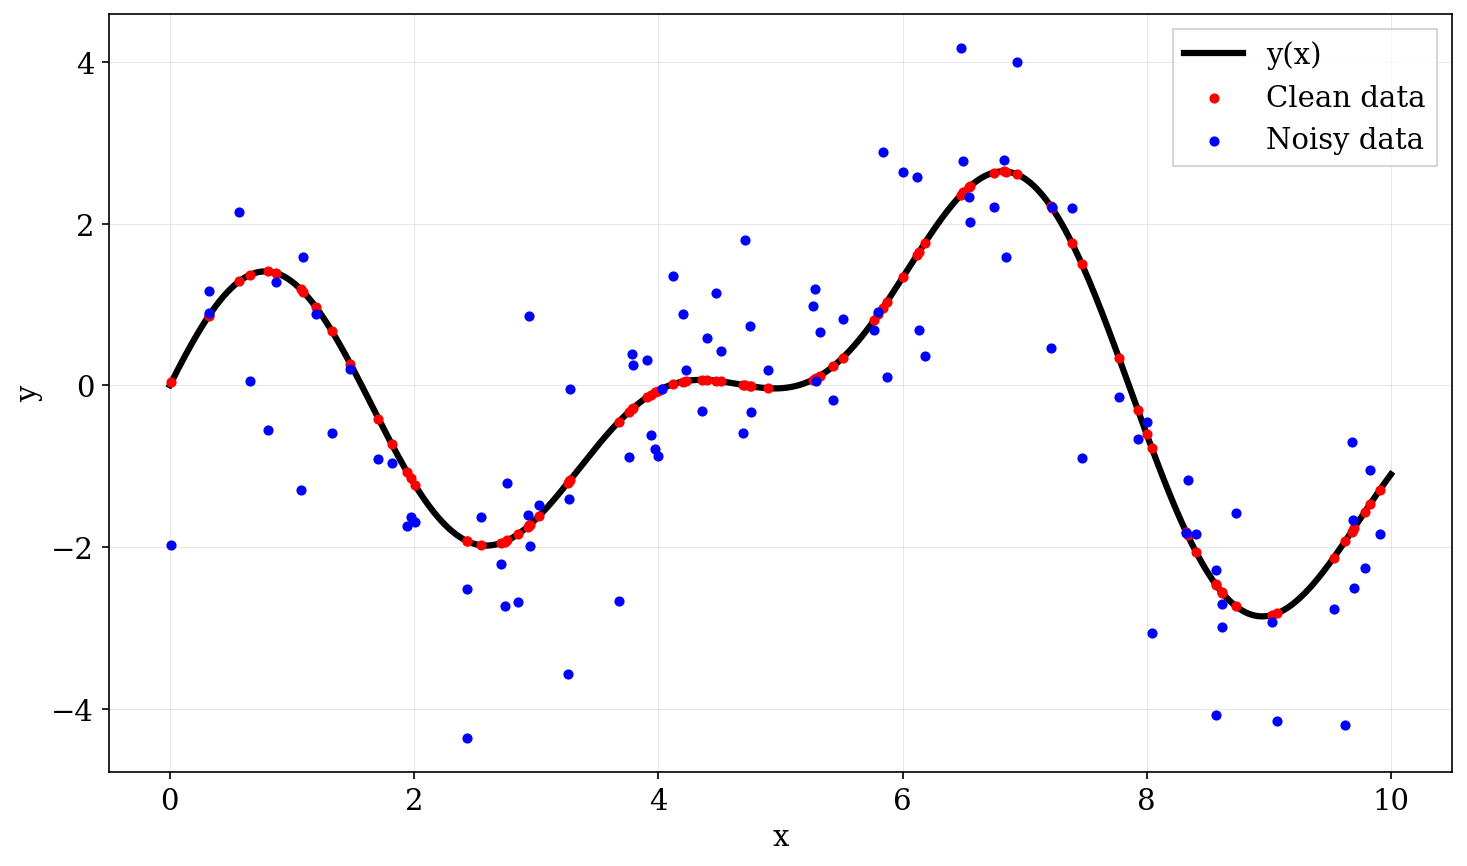

In [145]:
# -- 1. Generate data --
# generate data points
n = 100
x = np.sort(np.random.uniform(0, 10, n))
xs = np.sort(np.random.uniform(0, 10, n**2))
err = np.random.randn(n)

# plotting
plt.plot(xs, y(xs), c='k', lw=3, label='y(x)')
plt.scatter(x, y(x), c='r', s=15, zorder=5, label='Clean data')
plt.scatter(x, y(x, err), c='b', s=15, zorder=5, label='Noisy data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig(SAVEDIR + 'generated_data.png')
plt.show()

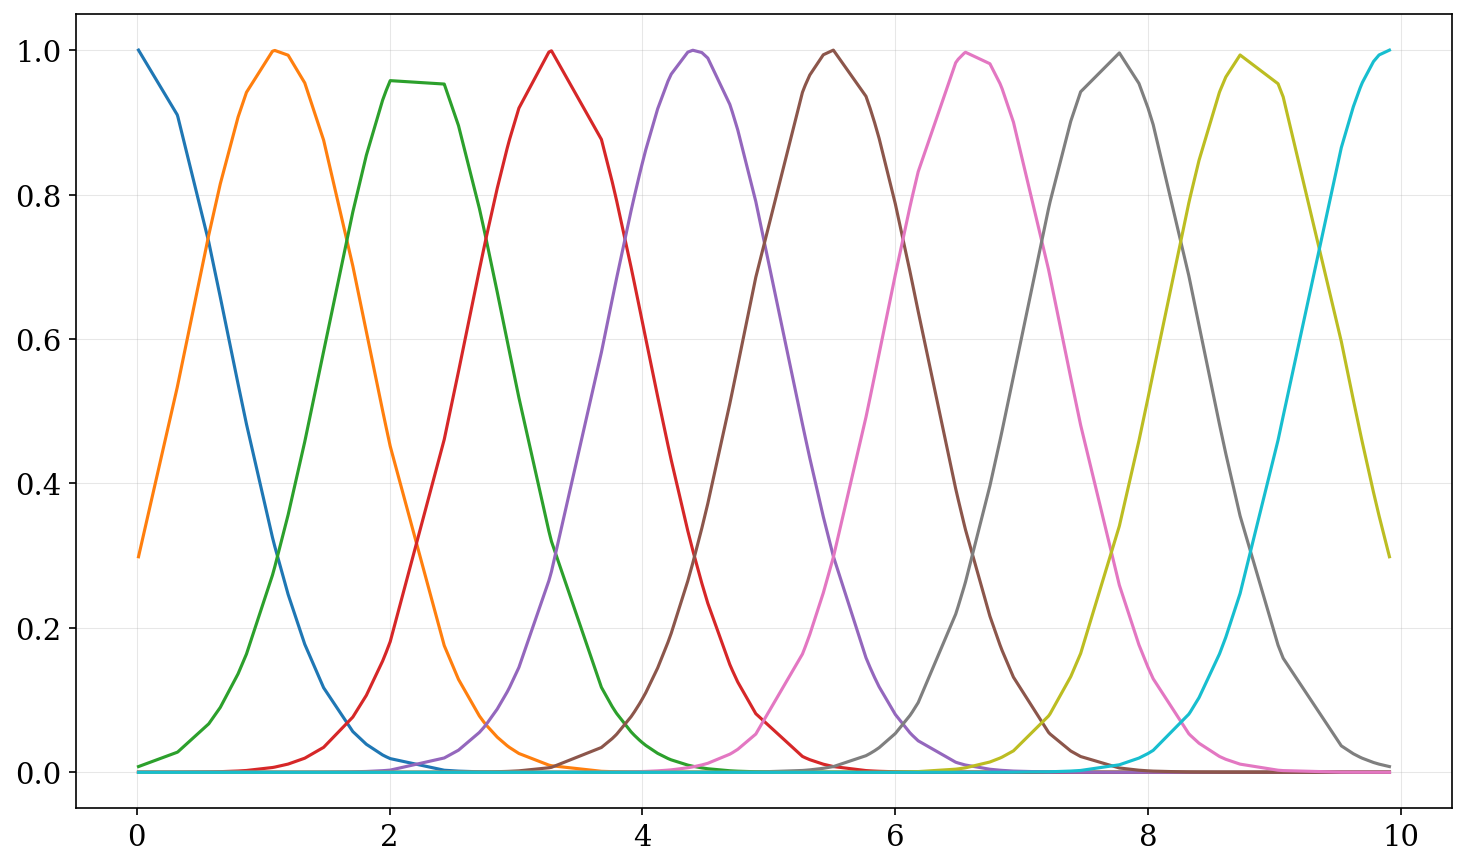

In [146]:
# -- 2. Non-linear basis --
# number of basis function D
D = 10

# generate means
bases = np.arange(0, D)
mu = np.min(x) + (np.max(x) - np.min(x))/(D-1) * bases
phi = gaussian(x[:,None], mu[None,:])

# plot gaussians
for d in range(D):
  plt.plot(x, phi[:,d])
  
plt.savefig(SAVEDIR + '10_gaussian_bases.png')
plt.show()

#### Model Fitting and Selection

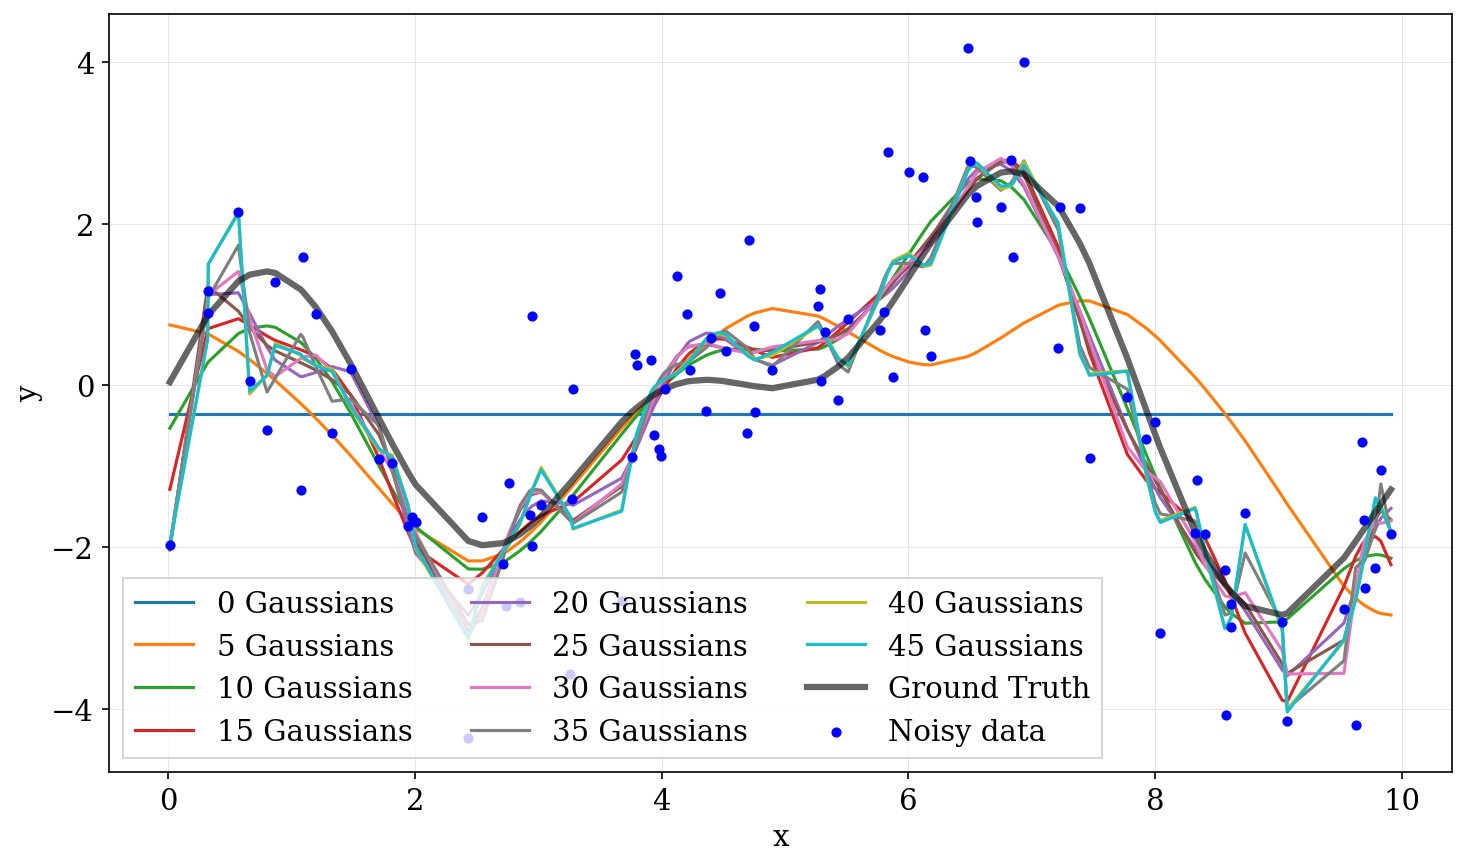

In [147]:
# -- 3. Model fitting
D = np.arange(0,45+1, 5)  # varying the number of basis functions (0 to 45)

d45_phi = None  # save D=45 data for later use

plt.figure()
for d in D:
  model = LinearRegression()
  bases = np.arange(0, d)
  mu = np.min(x) + (np.max(x) - np.min(x))/(d-1) * bases
  phi = gaussian(x[:,None], mu[None,:])
  if d==45:
    d45_phi = phi

  yh = model.fit_analytical(phi, y(x,err)).predict(phi)

  plt.plot(x, yh, label=f'{d} Gaussians')

plt.plot(x, y(x), c='k', lw=3, alpha=.6, label='Ground Truth')
plt.scatter(x, y(x, err), c='b', s=15, zorder=5, label='Noisy data')

plt.xlabel('x')
plt.ylabel('y')
plt.legend(ncols=3)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(SAVEDIR + 'model_fitting_with_various_D.png')
plt.show()

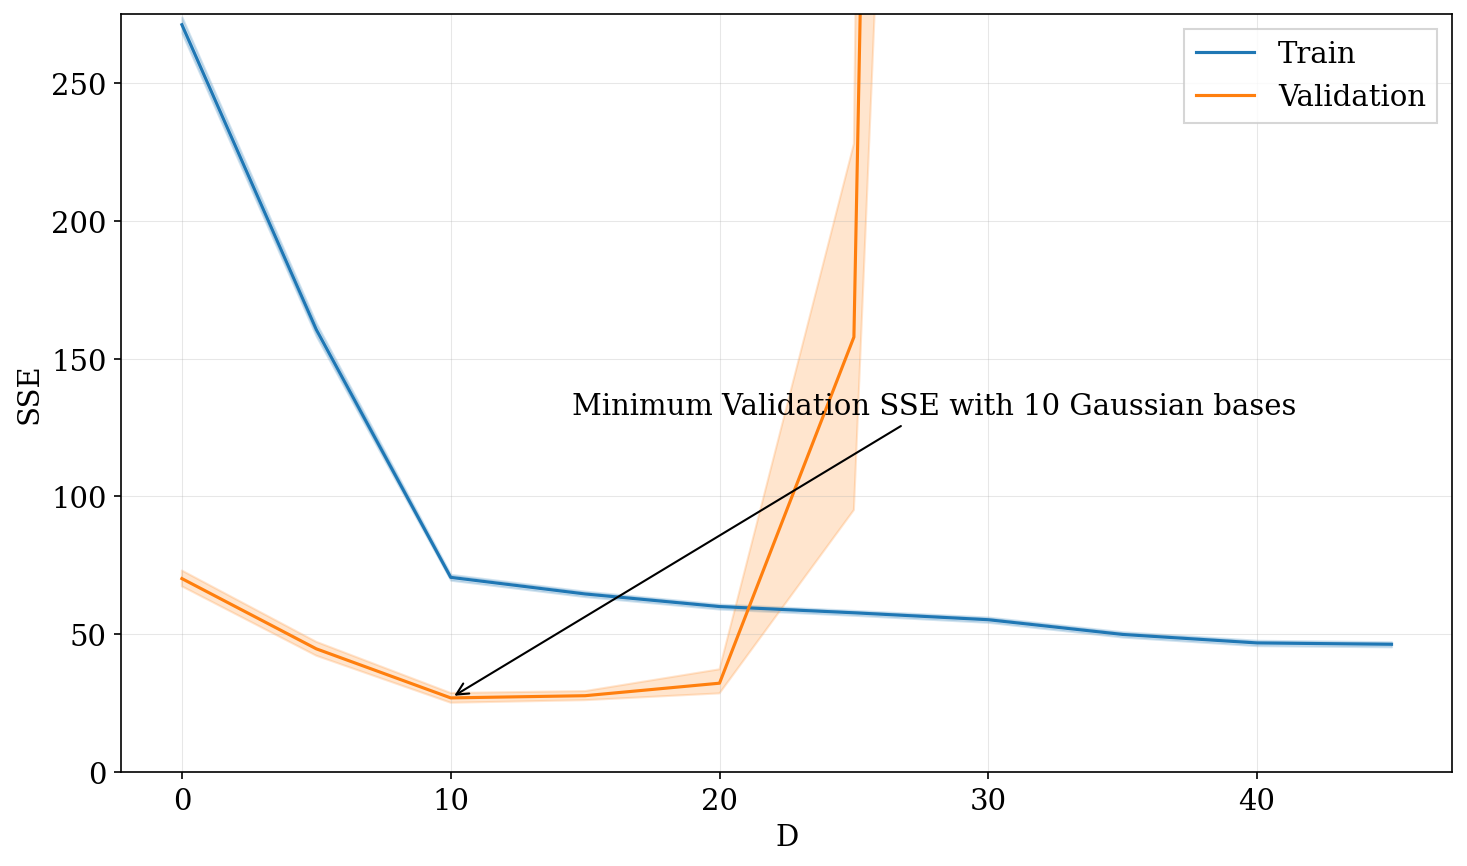

In [148]:
# -- 4. Model Selection

# train the models
# models = {}
# sse_train = []
# sse_val = []
results_list = []  # Collect results in a list instead of concatenating DataFrames
iterations = 128

for i in range(iterations):
  train_val_split = 0.8 # train/val split ratio
  trainsize = int(len(x)*train_val_split)

  # get the appropriate error for each datum
  np.random.seed(i)
  idx = np.random.choice(len(x), size=trainsize, replace=False)
  xtrain = x[idx]
  errtrain = err[idx]
  
  idx_val = np.setdiff1d(np.arange(len(x)), idx)
  xval = x[idx_val]
  errval = err[idx_val]
  
  # iterating over different model complexities
  D = np.arange(0,45+1, 5)
  for d in D:
    model = LinearRegression()
    bases = np.arange(0, d)
    mu = np.min(xtrain) + (np.max(xtrain) - np.min(xtrain))/(d-1) * bases
    phi = gaussian(xtrain[:,None], mu[None,:])

    yh = model.fit_analytical(phi, y(xtrain, errtrain)).predict(phi)

    sse_train = SSE(y(xtrain, errtrain), yh)
    sse_val = SSE(y(xval, errval), model.predict(gaussian(xval[:,None], mu[None,:])))
    
    results_list.append({
        'D': d, 
        'SSE_Train': sse_train, 
        'SSE_Val': sse_val, 
        'model': model,
        'iteration': i
    })

# create dataframe for convenient plotting
ssedf = pd.DataFrame(results_list)

# clean df to remove any infinite values
ssedf.replace([np.inf, -np.inf], np.nan, inplace=True)
ssedf.dropna(inplace=True)


# find smallest mean validation SSE
grouped = ssedf.groupby('D')['SSE_Val'].mean().reset_index()
valmin = grouped['SSE_Val'].min()
valmin_D = grouped['D'][np.where(grouped['SSE_Val'] == valmin)[0][0]]

plt.figure()

# plot with error bars being min and max
sns.lineplot(data=ssedf, x='D', y='SSE_Train', label='Train', errorbar=('ci', 95))
sns.lineplot(data=ssedf, x='D', y='SSE_Val', label='Validation', errorbar=('ci', 95))

# plt.plot(D, sse_train, label='Train')
# plt.plot(D, sse_val, label='Validation')
plt.annotate(f'Minimum Validation SSE with {valmin_D} Gaussian bases', (valmin_D, valmin), xytext=(28,130), ha='center', arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.xlabel('D')
plt.ylabel('SSE')

plt.ylim(0, 275)
plt.legend()
plt.savefig(SAVEDIR + 'train_val_sse_vs_D.png')
plt.show()

Best iteration for D=45 is 45 with SSE_val = 27.03001169075427. Setting as iteration for ALL model plots.


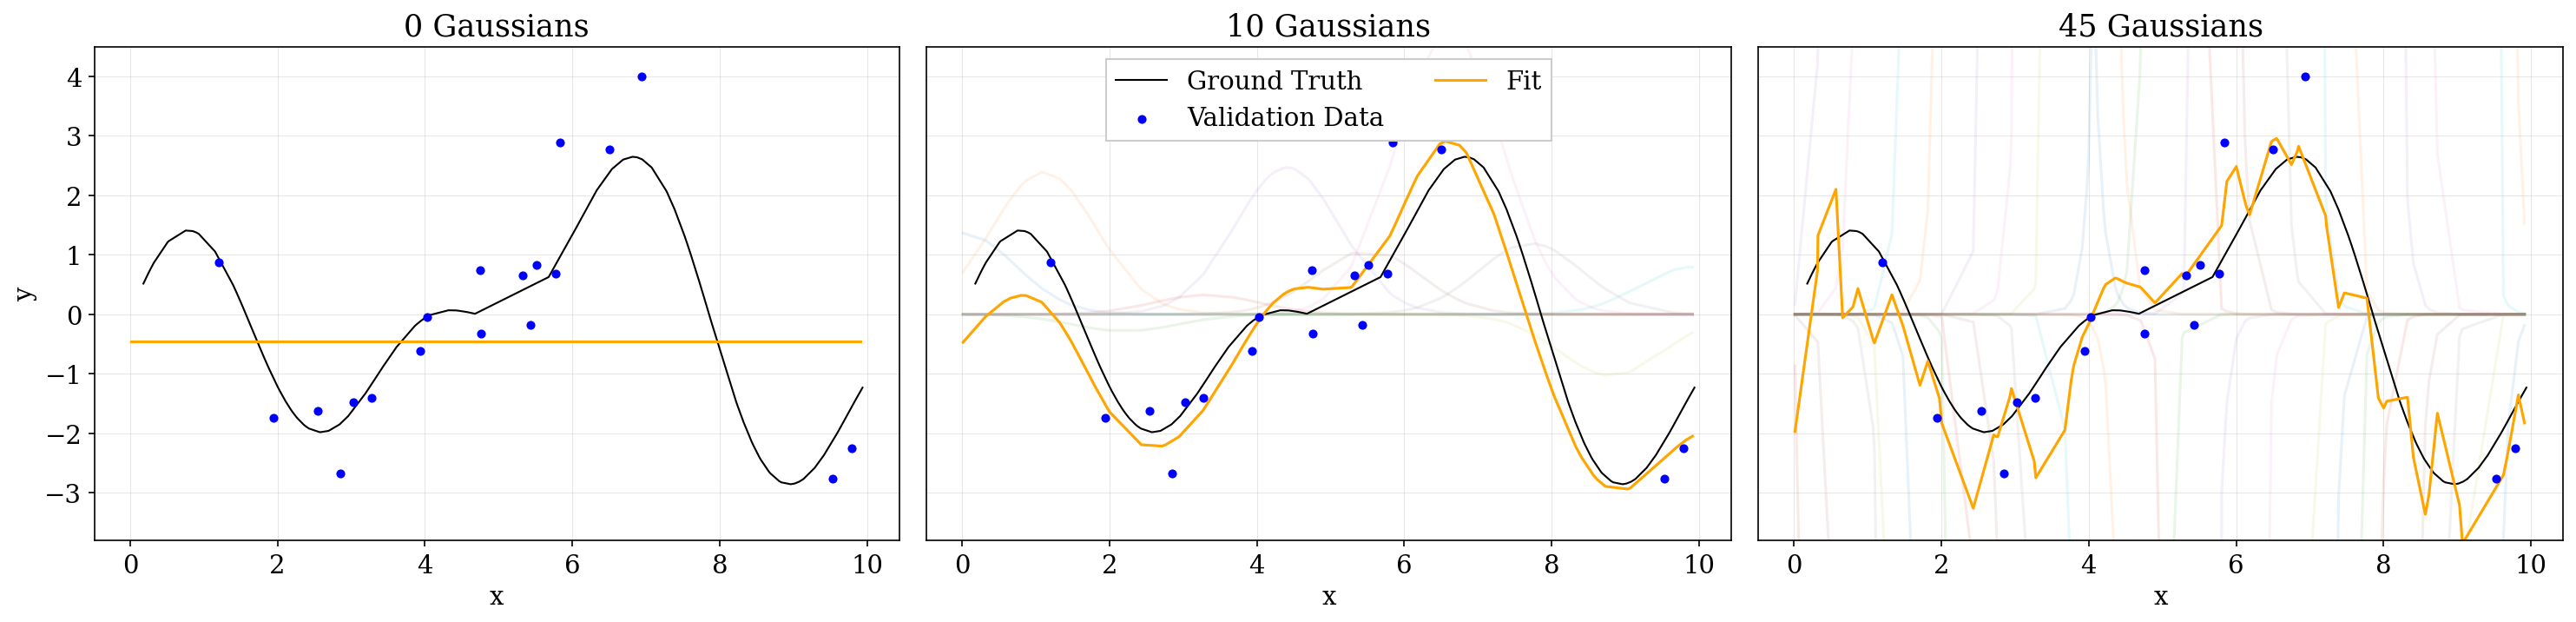

In [162]:
# -- 4. Continued...
best45model = ssedf.loc[ssedf['D'] == 45].sort_values(by='SSE_Val').iloc[0] # get best model for D=45
iteration = best45model['iteration'] # getting best iteration for D=45
print(f'Best iteration for D=45 is {iteration} with SSE_val = {best45model["SSE_Val"]}. Setting as iteration for ALL model plots.')

model0 = ssedf['model'][(ssedf['D'] == 0) & (ssedf['iteration'] == iteration)].values[0]
model10 = ssedf['model'][(ssedf['D'] == 10) & (ssedf['iteration'] == iteration)].values[0]
model45 = ssedf['model'][(ssedf['D'] == 45) & (ssedf['iteration'] == iteration)].values[0]

xtrain = np.sort(xtrain)
xval = np.sort(xval)

fig, [ax0, ax10, ax45] = plt.subplots(1, 3, figsize=(20,5), sharey=True)

# remove hspace
plt.subplots_adjust(wspace=0)
ax10.tick_params(left=False)
ax45.tick_params(left=False)

# 0 bases
ax0.set_title('0 Gaussians')
D = 0
bases = np.arange(0, D)
mu = np.min(xtrain) + (np.max(xtrain) - np.min(xtrain))/(D-1) * bases
phi = gaussian(xtrain[:,None], mu[None,:])

yh = model0.predict(phi)
# ax0.plot(xtrain, model0.w[-1]*np.ones_like(yh), label='Intercept')
ax0.plot(x, y(x), c='k', lw=1, label='Ground Truth')
ax0.scatter(xval, y(xval, errval), c='b', s=15, zorder=5, label='Validation Data')
ax0.plot(xtrain, yh, c='orange', label=f'Fit')
ax0.set_ylim(-3.8, 4.5)
ax0.set_ylabel('y')
ax0.set_xlabel('x')


# 10 gaussians
ax10.set_title('10 Gaussians')
D = 10
bases = np.arange(0, D)
mu = np.min(xtrain) + (np.max(xtrain) - np.min(xtrain))/(D-1) * bases
phi = gaussian(xtrain[:,None], mu[None,:])
yh = model10.predict(phi)
for d in range(D):
    ax10.plot(xtrain, model10.w[d]*phi[:,d], '-', alpha=.1)
# ax10.plot(xtrain, model10.w[-1]*np.ones_like(yh), label='Intercept')
ax10.plot(x, y(x), c='k', lw=1, label='Ground Truth')
ax10.scatter(xval, y(xval, errval), c='b', s=15, zorder=5, label='Validation Data')
ax10.plot(xtrain, yh, c='orange', label=f'Fit')
ax10.set_xlabel('x')
ax10.legend(loc='upper center', ncol=2, framealpha=1)


# 45 gaussians
ax45.set_title('45 Gaussians')
D = 45
bases = np.arange(0, D)
mu = np.min(xtrain) + (np.max(xtrain) - np.min(xtrain))/(D-1) * bases
phi = gaussian(xtrain[:,None], mu[None,:])
yh = model45.predict(phi)
for d in range(D):
    ax45.plot(xtrain, model45.w[d]*phi[:,d], '-', alpha=.1)
# ax45.plot(xtrain, model45.w[-1]*np.ones_like(yh), label='Intercept')
ax45.plot(x, y(x), c='k', lw=1, label='Ground Truth')
ax45.scatter(xval, y(xval, errval), c='b', s=15, zorder=5, label='Validation Data')
ax45.plot(xtrain, yh, c='orange', label=f'Fit')
ax45.set_xlabel('x')

plt.savefig(SAVEDIR + 'model_fitting_select_D.png')
plt.show()

## Task 2: Bias-Variance Tradeoff with Multiple Fits

Text(0, 0.5, 'y')

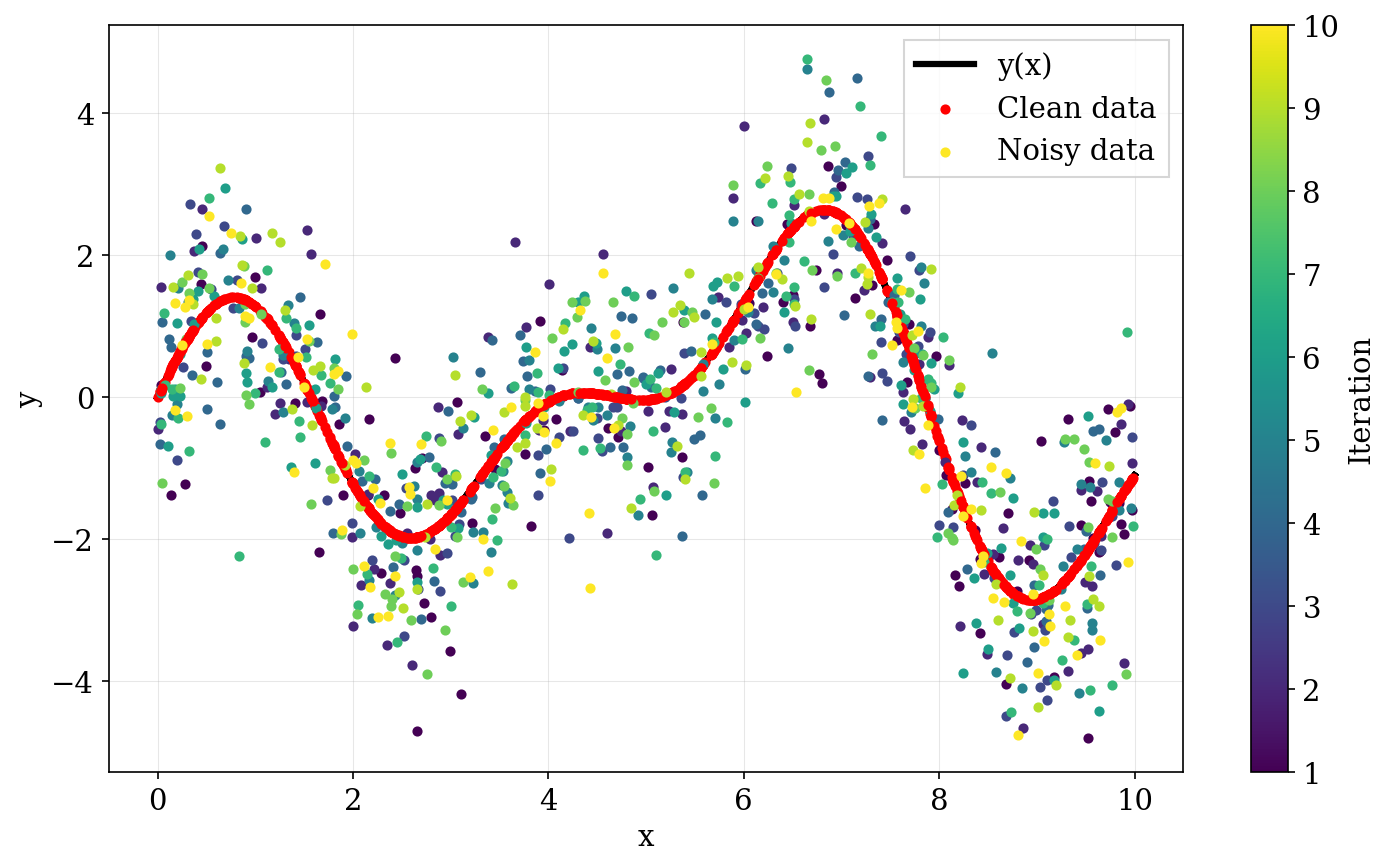

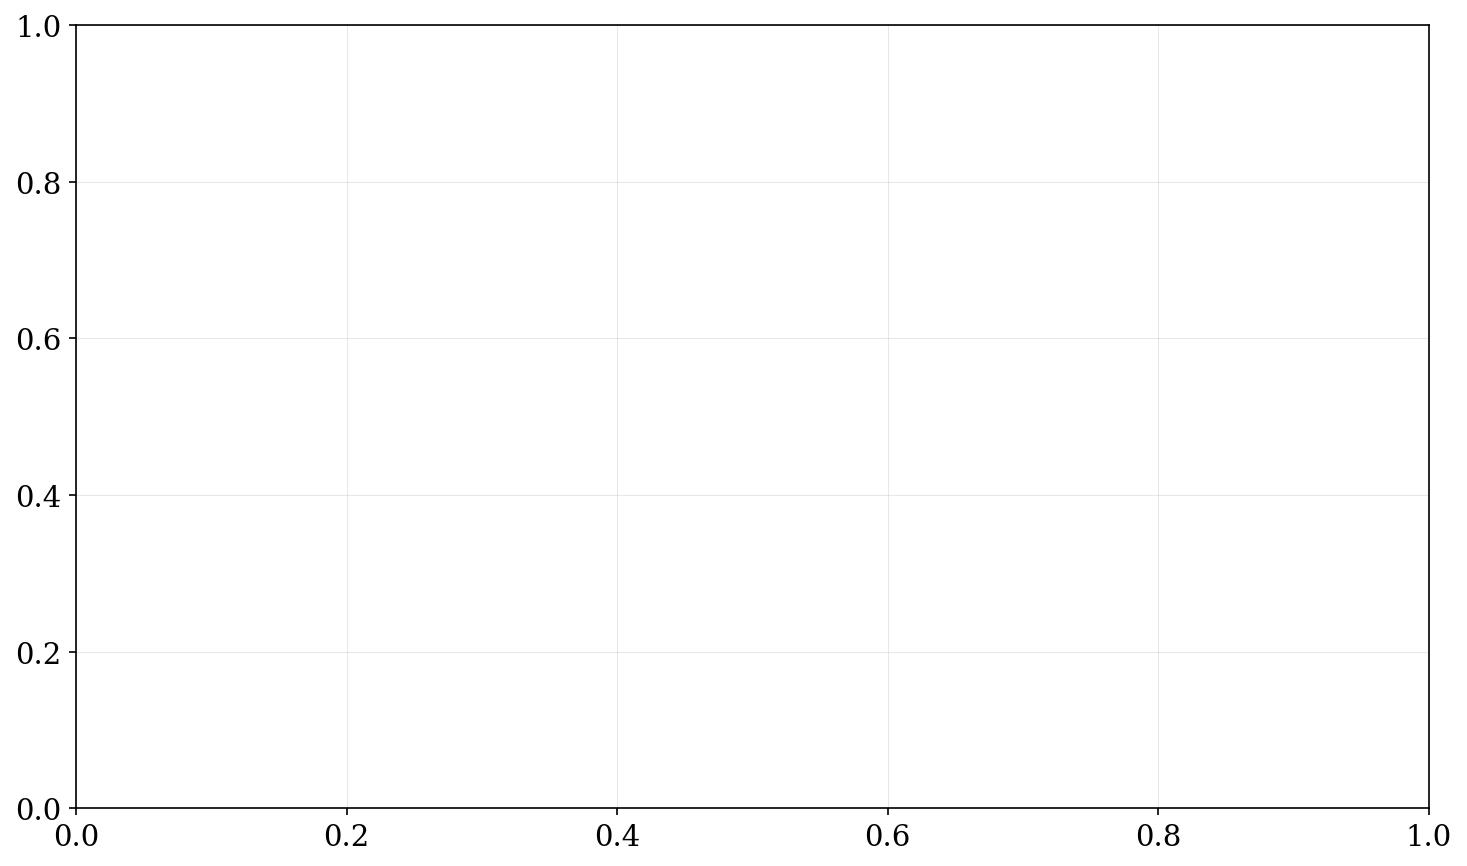

In [150]:
# will create multiple figures
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

# define colormap
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=10 - 1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax1)
cbar.set_label('Iteration')
cbar.ax.set_yticklabels([f'{i+1}' for i in range(10)])

for i in range(10):
    
    # generate the data:
    n = 100
    x = np.sort(np.random.uniform(0, 10, n))
    xs = np.sort(np.random.uniform(0, 10, n**2))
    err = np.random.randn(n)

    noisy_data = y(x, err)
    clean_data = y(x)

    color = cmap(i / (10 - 1))
    ax1.plot(xs, y(xs), c='k', lw=3, label='y(x)')
    ax1.scatter(x, y(x), c="r", s=15, zorder=5, label='Clean data')
    ax1.scatter(x, y(x, err), c=color, s=15, zorder=5, label='Noisy data')

handles, labels = ax1.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax1.legend(unique.values(), unique.keys())
ax1.set_xlabel('x')
ax1.set_ylabel('y')
#ax1.savefig(SAVEDIR + 'generated data.png')


## Task 3: Regularization with Cross-Validation

#### Cross-Validation

In [ ]:
# -- 2. Cross-Validation --
# Define parameters
num_folds = 10
reg_list = np.logspace(-3,1,10)  # regularization parameters to test
D = 45  # basis number
N = 20  # sampling number
num_datasets = 50
noise_variance = 1
learning_rate = .01
max_iters = 50

# generate constant x and phi grids for bias-variance analysis
x_prime = np.linspace(0, 1, N)
phi_prime = get_gaussian_basis(x_prime, D, sigma=1)
y_predictions = np.zeros((num_datasets, len(reg_list), N, 2))  # to store all y predictions

# To store MSE results
train_mse_l1 = np.zeros((num_datasets, len(reg_list)))
val_mse_l1   = np.zeros((num_datasets, len(reg_list)))
train_mse_l2 = np.zeros((num_datasets, len(reg_list)))
val_mse_l2   = np.zeros((num_datasets, len(reg_list)))

# Sample different datasets
for dataset_idx in range(num_datasets):
    # Generate dataset
    x_dataset, y_dataset, noise = sample_dataset(N, noise_variance)
    phi = get_gaussian_basis(x_dataset, D, sigma=1)  # Create gaussian basis

    # Go through regularization parameters
    for lam_idx, reg_coef in enumerate(reg_list):
        # Run k-fold CV for this dataset and λ
        res = k_fold_cv(phi, y_dataset, err=noise, num_folds=num_folds, reg_coef=reg_coef,
                        learning_rate=learning_rate, max_iters=max_iters, x_prime=phi_prime)
        
        # Store y predictions for this parameter
        y_predictions[dataset_idx,lam_idx,:,0] = res['l1_y_pred']
        y_predictions[dataset_idx,lam_idx,:,1] = res['l2_y_pred']
        
        # Save results for this parameter
        train_mse_l1[dataset_idx, lam_idx] = res['l1_MSE']['avg_train_MSE']
        val_mse_l1[dataset_idx, lam_idx]   = res['l1_MSE']['avg_val_MSE']
        train_mse_l2[dataset_idx, lam_idx] = res['l2_MSE']['avg_train_MSE']
        val_mse_l2[dataset_idx, lam_idx]   = res['l2_MSE']['avg_val_MSE']

In [154]:
# -- Average MSE over datasets --
# l1
mean_train_mse_l1 = np.mean(train_mse_l1, axis=0)
train_mse_l1_std = np.std(train_mse_l1, axis=0)
mean_val_mse_l1   = np.mean(val_mse_l1, axis=0)
val_mse_l1_std   = np.std(val_mse_l1, axis=0)
# l2
mean_train_mse_l2 = np.mean(train_mse_l2, axis=0)
train_mse_l2_std = np.std(train_mse_l2, axis=0)
mean_val_mse_l2   = np.mean(val_mse_l2, axis=0)
val_mse_l2_std = np.std(val_mse_l2, axis=0)

In [155]:
# -- Selecting optimal λ --
# L1
optimal_lam_idx_l1 = np.argmin(mean_val_mse_l1)
optimal_lam_l1 = reg_list[optimal_lam_idx_l1]
print(f'Optimal λ for L1 regularization: {optimal_lam_l1}')

# L2
optimal_lam_idx_l2 = np.argmin(mean_val_mse_l2)
optimal_lam_l2 = reg_list[optimal_lam_idx_l2]
print(f'Optimal λ for L2 regularization: {optimal_lam_l2}')

Optimal λ for L1 regularization: 0.001
Optimal λ for L2 regularization: 0.001


#### Plotting

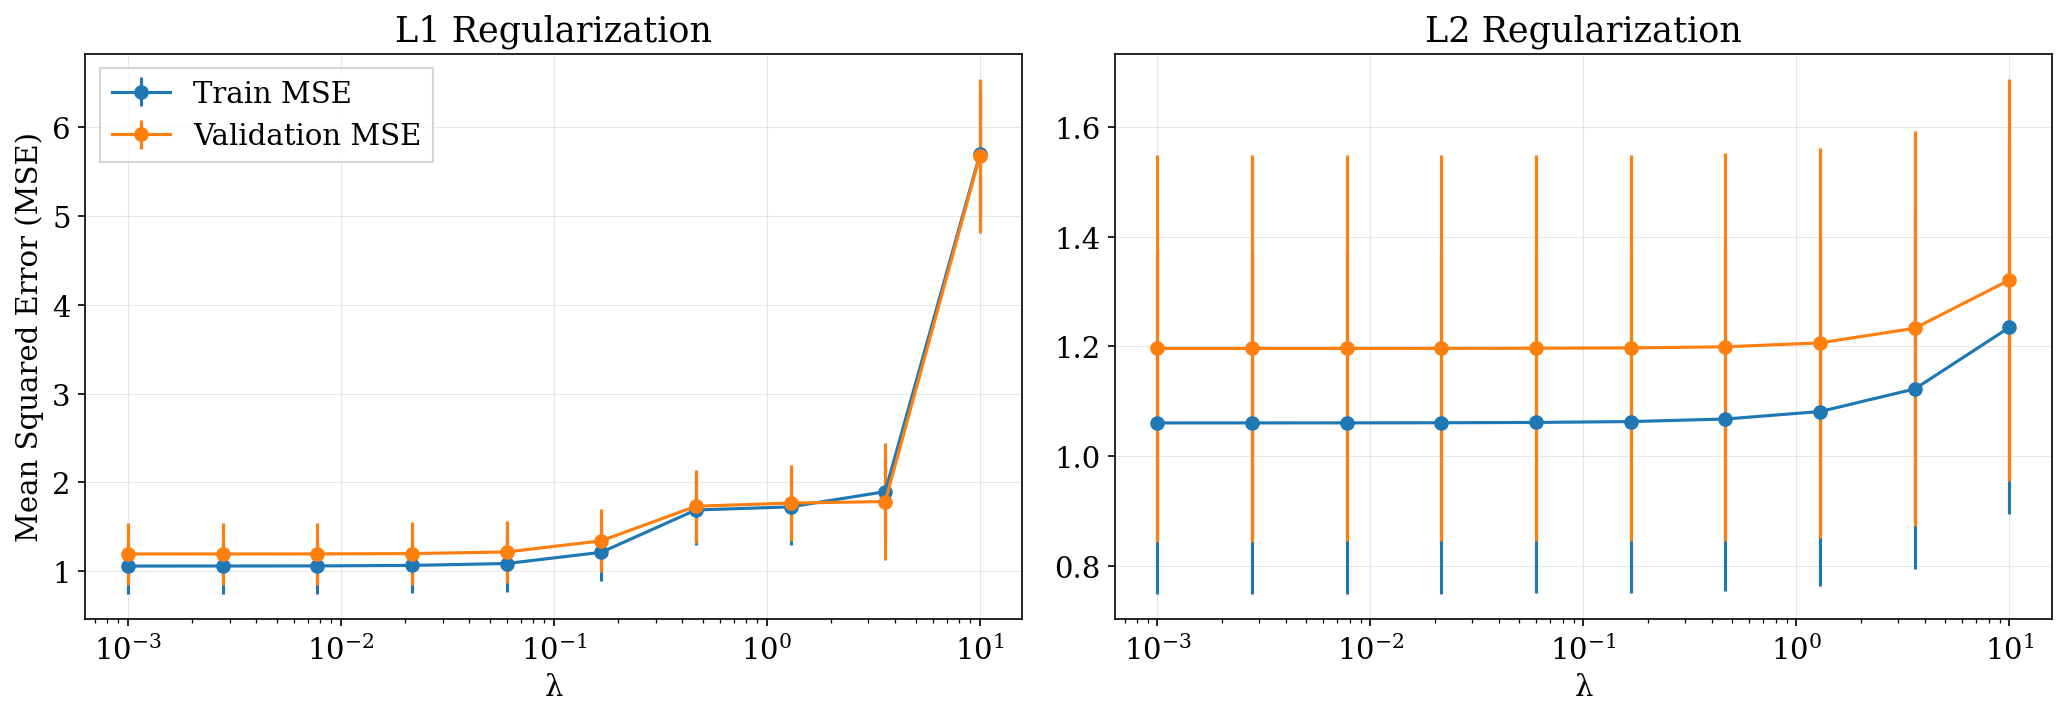

In [156]:
# -- 3. Plotting Train and Validation Errors --
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

# Plot l1 results
ax1.errorbar(reg_list, mean_train_mse_l1, yerr=train_mse_l1_std, label='Train MSE', fmt='-o')
ax1.errorbar(reg_list, mean_val_mse_l1, yerr=val_mse_l1_std, label='Validation MSE', fmt='-o')
ax1.set_title('L1 Regularization')
ax1.set_ylabel('Mean Squared Error (MSE)')
ax1.legend()

# Plot l2 results
ax2.errorbar(reg_list, mean_train_mse_l2, yerr=train_mse_l2_std, label='Train MSE', fmt='-o')
ax2.errorbar(reg_list, mean_val_mse_l2, yerr=val_mse_l2_std, label='Validation MSE', fmt='-o')
ax2.set_title('L2 Regularization')

for ax in [ax1, ax2]:
    ax.set_xscale('log')
    ax.set_xlabel('λ')
    ax.grid(True)
plt.savefig(SAVEDIR + 'train_val_mse_vs_lambda.png')
plt.show()

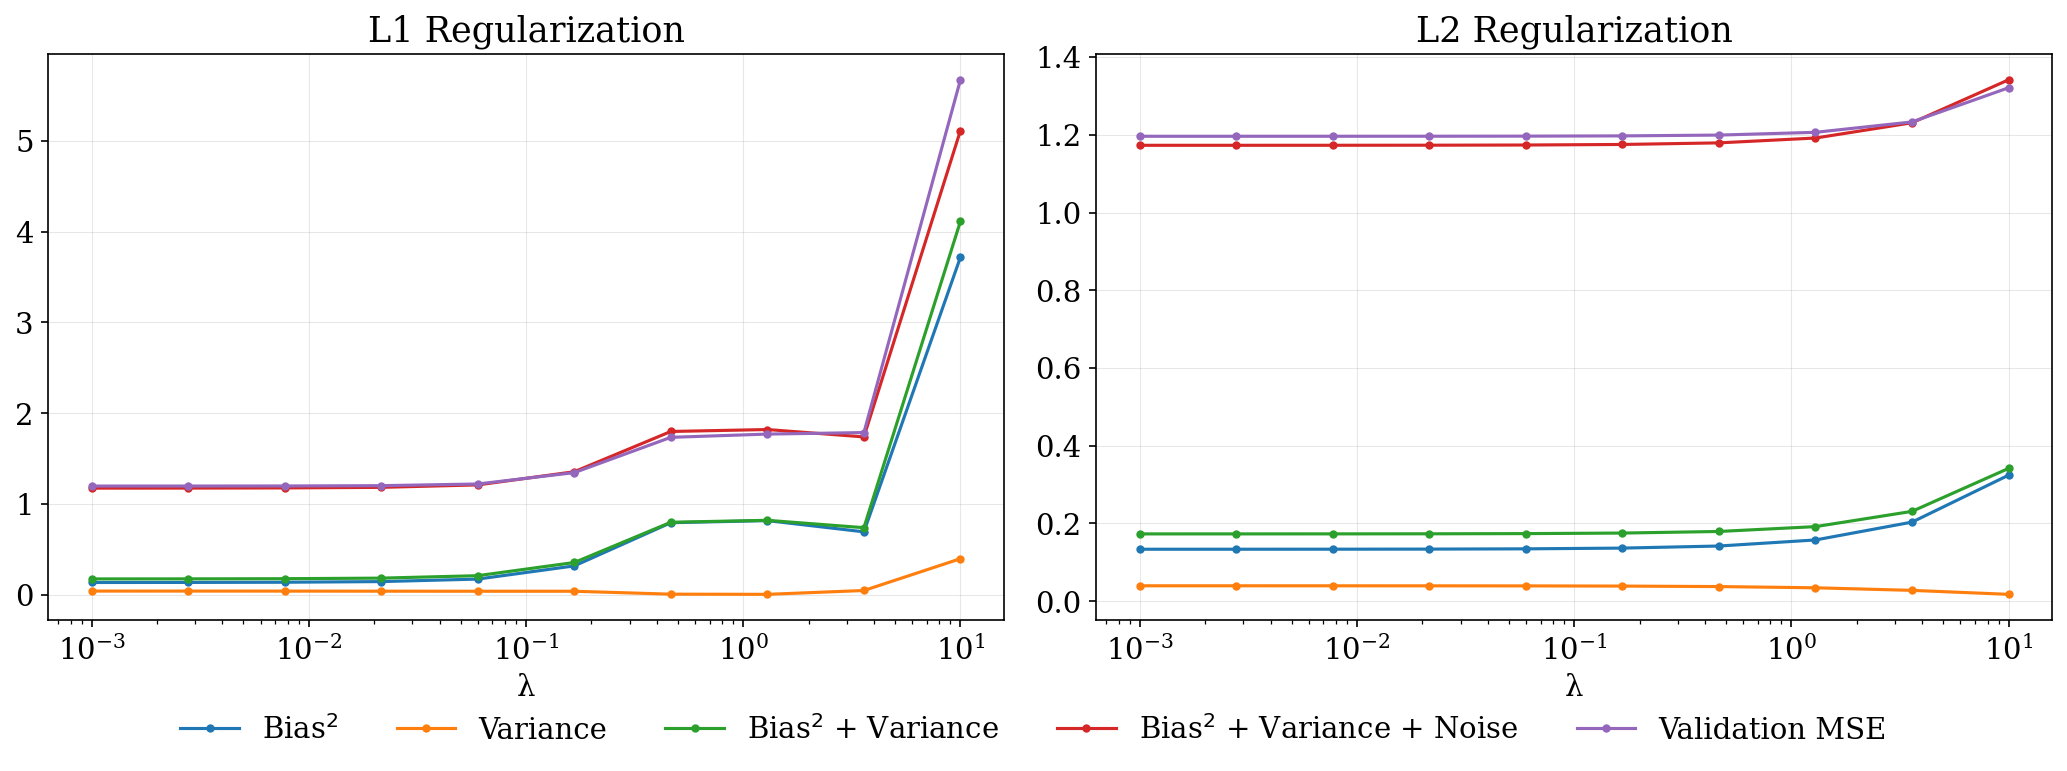

In [160]:
# -- 4. Plotting Bias-Variance Decomposition --
# Compute bias and variance, both shape (len(reg_list), 2)
bias_squared, variance = compute_bias_variance(y_predictions, y(x_prime))

# Plot
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

# L1 Regularization
ax1.plot(reg_list, bias_squared[:,0], label=r'Bias$^2$', marker='.')
ax1.plot(reg_list, variance[:,0], label='Variance', marker='.')
ax1.plot(reg_list, bias_squared[:,0] + variance[:,0], label=r'Bias$^2$ + Variance', marker='.')
ax1.plot(reg_list, bias_squared[:,0] + variance[:,0] + noise_variance, label=r'Bias$^2$ + Variance + Noise', marker='.')
ax1.plot(reg_list, mean_val_mse_l1, label='Validation MSE', marker='.')
ax1.set_title('L1 Regularization')
ax1.set_xscale('log')
ax1.set_xlabel('λ')
ax1.grid(True)

# L2 Regularization
ax2.plot(reg_list, bias_squared[:,1], label=r'Bias$^2$', marker='.')
ax2.plot(reg_list, variance[:,1], label='Variance', marker='.')
ax2.plot(reg_list, bias_squared[:,1] + variance[:,1], label=r'Bias$^2$ + Variance', marker='.')
ax2.plot(reg_list, bias_squared[:,1] + variance[:,1] + noise_variance, label=r'Bias$^2$ + Variance + Noise', marker='.')
ax2.plot(reg_list, mean_val_mse_l2, label='Validation MSE', marker='.')
ax2.set_title('L2 Regularization')
ax2.set_xscale('log')
ax2.set_xlabel('λ')
ax2.grid(True)

# Shared legend below both panels
handles, labels = ax2.get_legend_handles_labels()
figure.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=5,
    frameon=False
)

plt.tight_layout()
plt.savefig(SAVEDIR + 'bias_variance_decomposition.png')
plt.show()

## Task 4: Effect of L1 and L2 Regularization on Loss

In [158]:
"""
Minimum Deliverables
• Contour Plots: Contour plots of the loss function for L1 and L2 regularization with varying strengths.
• Optimization Paths: Plots showing the trajectory of gradient descent for different regularization strengths.
• Analysis: Based on the plots, provide observations about the impact of L1 and L2 regularization on the model’s weights and performance.
"""

'\nMinimum Deliverables\n• Contour Plots: Contour plots of the loss function for L1 and L2 regularization with varying strengths.\n• Optimization Paths: Plots showing the trajectory of gradient descent for different regularization strengths.\n• Analysis: Based on the plots, provide observations about the impact of L1 and L2 regularization on the model’s weights and performance.\n'

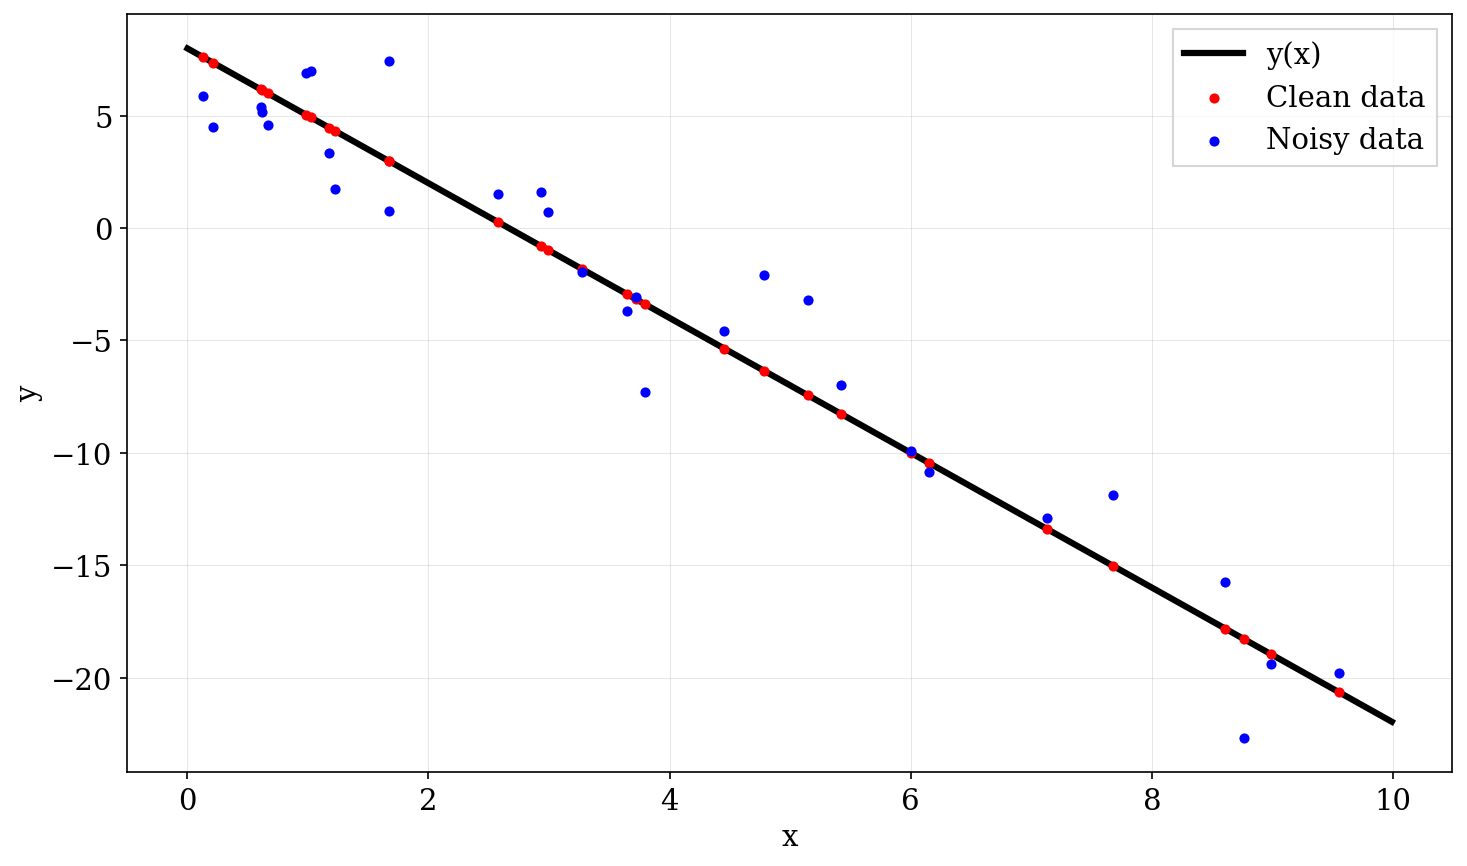

In [174]:
# -- 1. Generating Synthetic Data --
# generate data points
n = 30
x = np.sort(np.random.uniform(0, 10, n))
noise = np.random.randn(n)
y_clean = y_task4(x)
y_noisy = y_task4(x, noise)

x_true = np.sort(np.random.uniform(0, 10, n**2))
y_true = y_task4(x_true)

# plotting
plt.plot(x_true, y_true, c='k', lw=3, label='y(x)')
plt.scatter(x, y_clean, c='r', s=15, zorder=5, label='Clean data')
plt.scatter(x, y_noisy, c='b', s=15, zorder=5, label='Noisy data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 30)

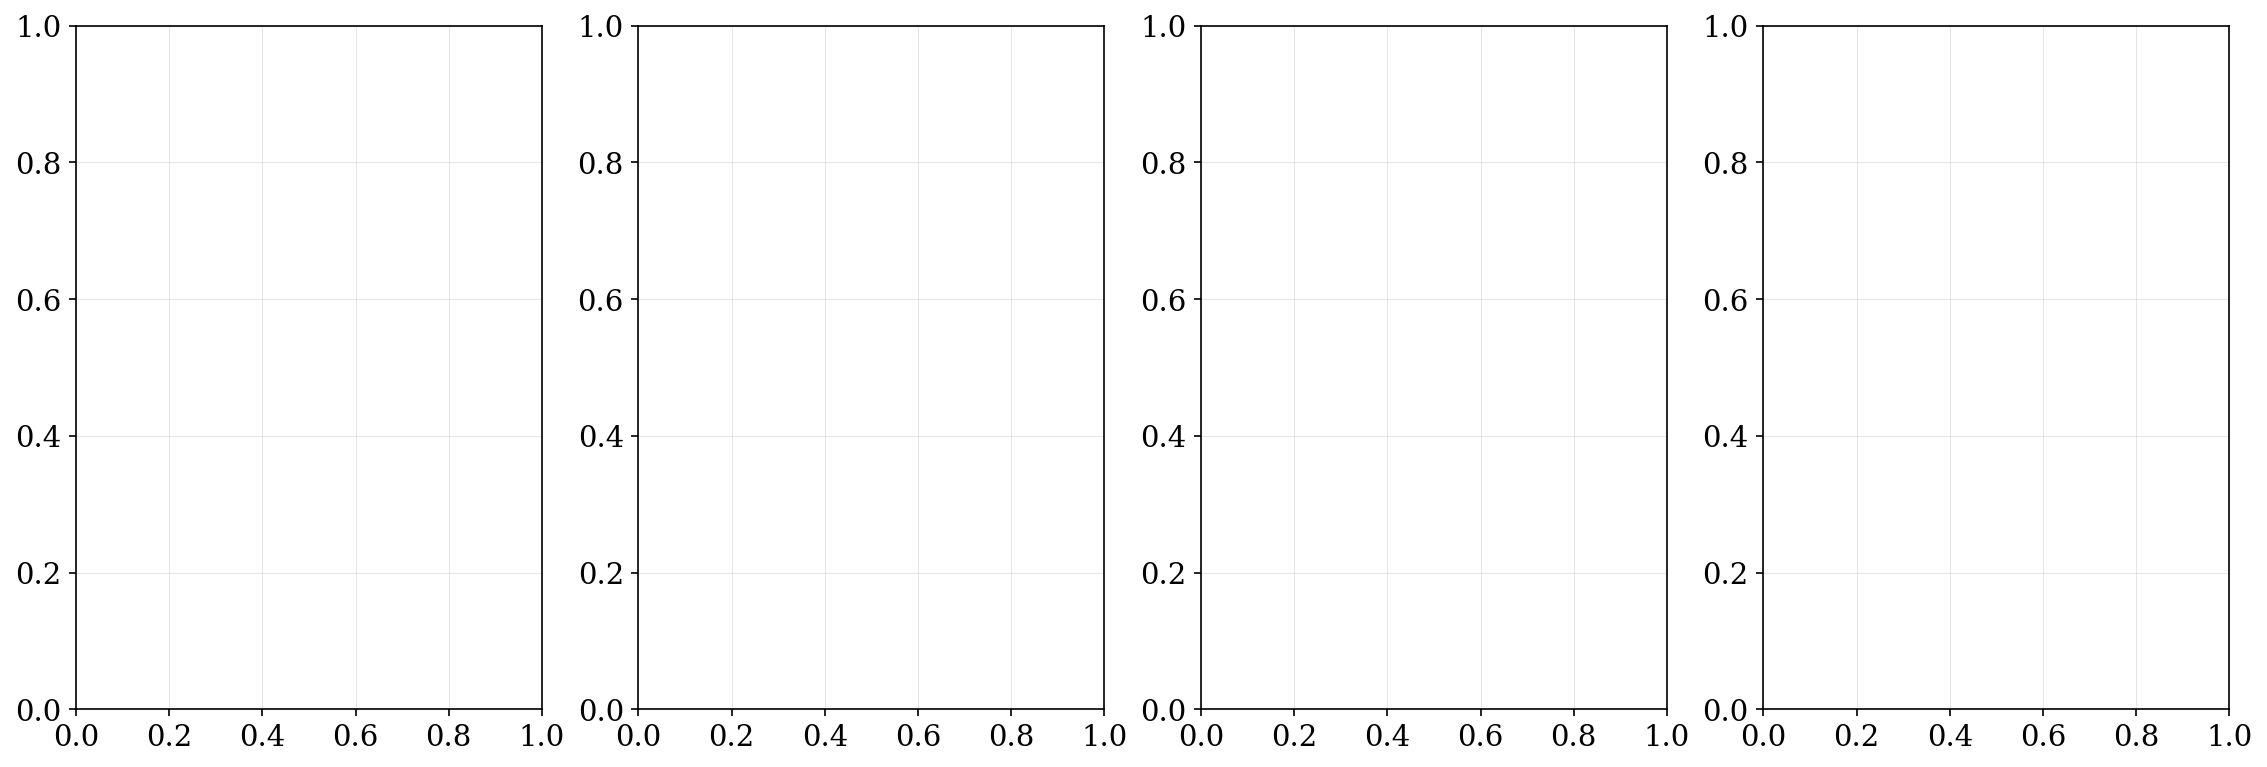

In [175]:
# -- 2. Applying L1 and L2 Regularization --
# Define parameters
reg_list = [0.01, 0.1, 1, 10]  # regularization strengths to test
fig, axes = plt.subplots(ncols=len(reg_list), nrows=1, constrained_layout=True, figsize=(15, 5))

# L1 regularization
cost_l1 = lambda w, reg: .5*np.mean((w[0] + w[1]*x - y)**2) + reg*np.sum(np.abs(w))
for i, reg_coef in enumerate(reg_list):
    # Set up optimizer and model
    optimizer_l1 = GradientDescent(learning_rate=.01, max_iters=50, record_history=True)
    model_l1 = LinearRegression(l1_reg=reg_coef)
    model_l1.fit_gd_regularized(x, y_noisy, optimizer_l1, reg_type='l1')  # fit for w params
    
    # define cost function for contour plot
    current_cost = lambda w: cost_reg(w, x, y_noisy, reg=reg_coef, reg_type='l1')
    plot_contour(current_cost, [-20,20], [-20,20], 100, axes[i])
    w_hist = np.vstack(optimizer_l1.w_history)# T x 2

    # plot optimization path
    axes[i].plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8)
    axes[i].plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3)
    axes[i].set_xlabel(r'$w_0$')
    axes[i].set_ylabel(r'$w_1$')
    axes[i].set_title(f' lambda = {reg_coef}')
    axes[i].set_xlim([-20,20])
    axes[i].set_ylim([-5,5])
plt.show()


# L2 regularization
cost_l2 = lambda w, reg: .5*np.mean((w[0] + w[1]*x - y)**2) + reg*np.dot(w,w)/2
for i, reg_coef in enumerate(reg_list):
    # Set up optimizer and model
    optimizer_l2 = GradientDescent(learning_rate=.01, max_iters=50, record_history=True)
    model_l2 = LinearRegression(l2_reg=reg_coef)
    model_l2.fit_gd_regularized(x, y_noisy, optimizer_l2, reg_type='l2')  # fit for w params
    
    # define cost function for contour plot
    current_cost = lambda w: cost_reg(w, x, y_noisy, reg=reg_coef, reg_type='l2')
    plot_contour(current_cost, [-20,20], [-20,20], 100, axes[i])
    w_hist = np.vstack(optimizer_l2.w_history)# T x 2

    # plot optimization path
    axes[i].plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8)
    axes[i].plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3)
    axes[i].set_xlabel(r'$w_0$')
    axes[i].set_ylabel(r'$w_1$')
    axes[i].set_title(f' lambda = {reg_coef}')
    axes[i].set_xlim([-20,20])
    axes[i].set_ylim([-5,5])
